# Multicut

Use the `elf.segmentation` module for boundary based multicut segmentation: [Multicut brings automated neurite segmentation closer to human performance](https://www.nature.com/articles/nmeth.4151). We use data from the [ISBI 2012 EM Segmentation challenge](http://brainiac2.mit.edu/isbi_challenge/home) and [The Mutex Watershed: Efficent, Parameter-Free Image Partitionong](http://openaccess.thecvf.com/content_ECCV_2018/html/Steffen_Wolf_The_Mutex_Watershed_ECCV_2018_paper.html).
You can obtain the example data [here](https://hcicloud.iwr.uni-heidelberg.de/index.php/s/6LuE7nxBN3EFRtL).

The boundary based segmentation approach works as follows:
1. Predict pixel-wise affinity (or boundary) map. Here, we use pre-computed results for this step.
2. Compute a watershed over-segmentation based on the affinity maps.
3. Compute the region adjacency graph defined by the watershed over-segmentation.
4. Compute weights for the edges of this graph by accumulating the affinity (or boundary) map over the edge pixels.
5. Partition the graph based on the edge weights via Multicut and project the result back to the pixel level.

# Import data: raw data and probability map from model

In [1]:
%gui qt 
import imageio
# import napari for data visualisation
import napari
import os
os.environ['OMP_NUM_THREADS'] = '1'

from elf.io import open_file
import tifffile

import numpy as np
import unittest
import skimage
import pandas as pd
from skimage.segmentation import relabel_sequential
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt
from pathlib import Path
import functions_multicut as func

In [2]:
# import image and prediction from UNet 3D
data_path = '../New_data_UNet3DCelegans2024/data/images_test_stacked_channels/NDAcquisition5.tif'
raw = tifffile.imread(data_path)  # Z, Y, X
# Extraer el nombre del archivo con extensión
filename_with_ext = os.path.basename(data_path)

# Eliminar la extensión
filenam_without_ext = Path(filename_with_ext).stem

pmap_path = '../ouputs_chtc/output_185/NDAcquisition5_prediction.tiff'
#'/Users/llanos/Documents/UNet_3D_C_elegans/ouputs_chtc/output_126/mx85-nd-acquisition-4-stacked-channels_prediction.tiff'

pmaps = 1. - np.asarray(imageio.volread(pmap_path))
pmaps_invert = np.asarray(imageio.volread(pmap_path))

pmaps_32 = pmaps.astype('float32')
pmaps_32_invert = pmaps_invert.astype('float32')

## Run run_multicut_callum() function and open in Napari

In [ ]:
final_seg_callum = func.run_multicut_callum(pmaps_32_invert)
viewer = napari.Viewer()
#viewer.add_image(raw, name='raw')
viewer.add_image(pmaps_32_invert, name='boundaries')
viewer.add_labels(final_seg_callum, name='multicut_callum')

<Labels layer 'multicut_callum' at 0x3cdf7c040>

# Set of configurations parameters for watershed and probability costs

In [ ]:
configs_ws = [
{"sigma_seeds": 2.0, "threshold": 0.2, "min_size": 20},
{"sigma_seeds": 2.0, "threshold": 0.3, "min_size": 20},
{"sigma_seeds": 2.0, "threshold": 0.4, "min_size": 20},
{"sigma_seeds": 2.0, "threshold": 0.5, "min_size": 20},
{"sigma_seeds": 2.0, "threshold": 0.6, "min_size": 20},
{"sigma_seeds": 2.0, "threshold": 0.7, "min_size": 20},
{"sigma_seeds": 2.0, "threshold": 0.8, "min_size": 20},
]
#beta_values = [0.7, 0.8, 0.9]
beta_values = [0.5, 0.6]

# Run function run_multicut_test

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


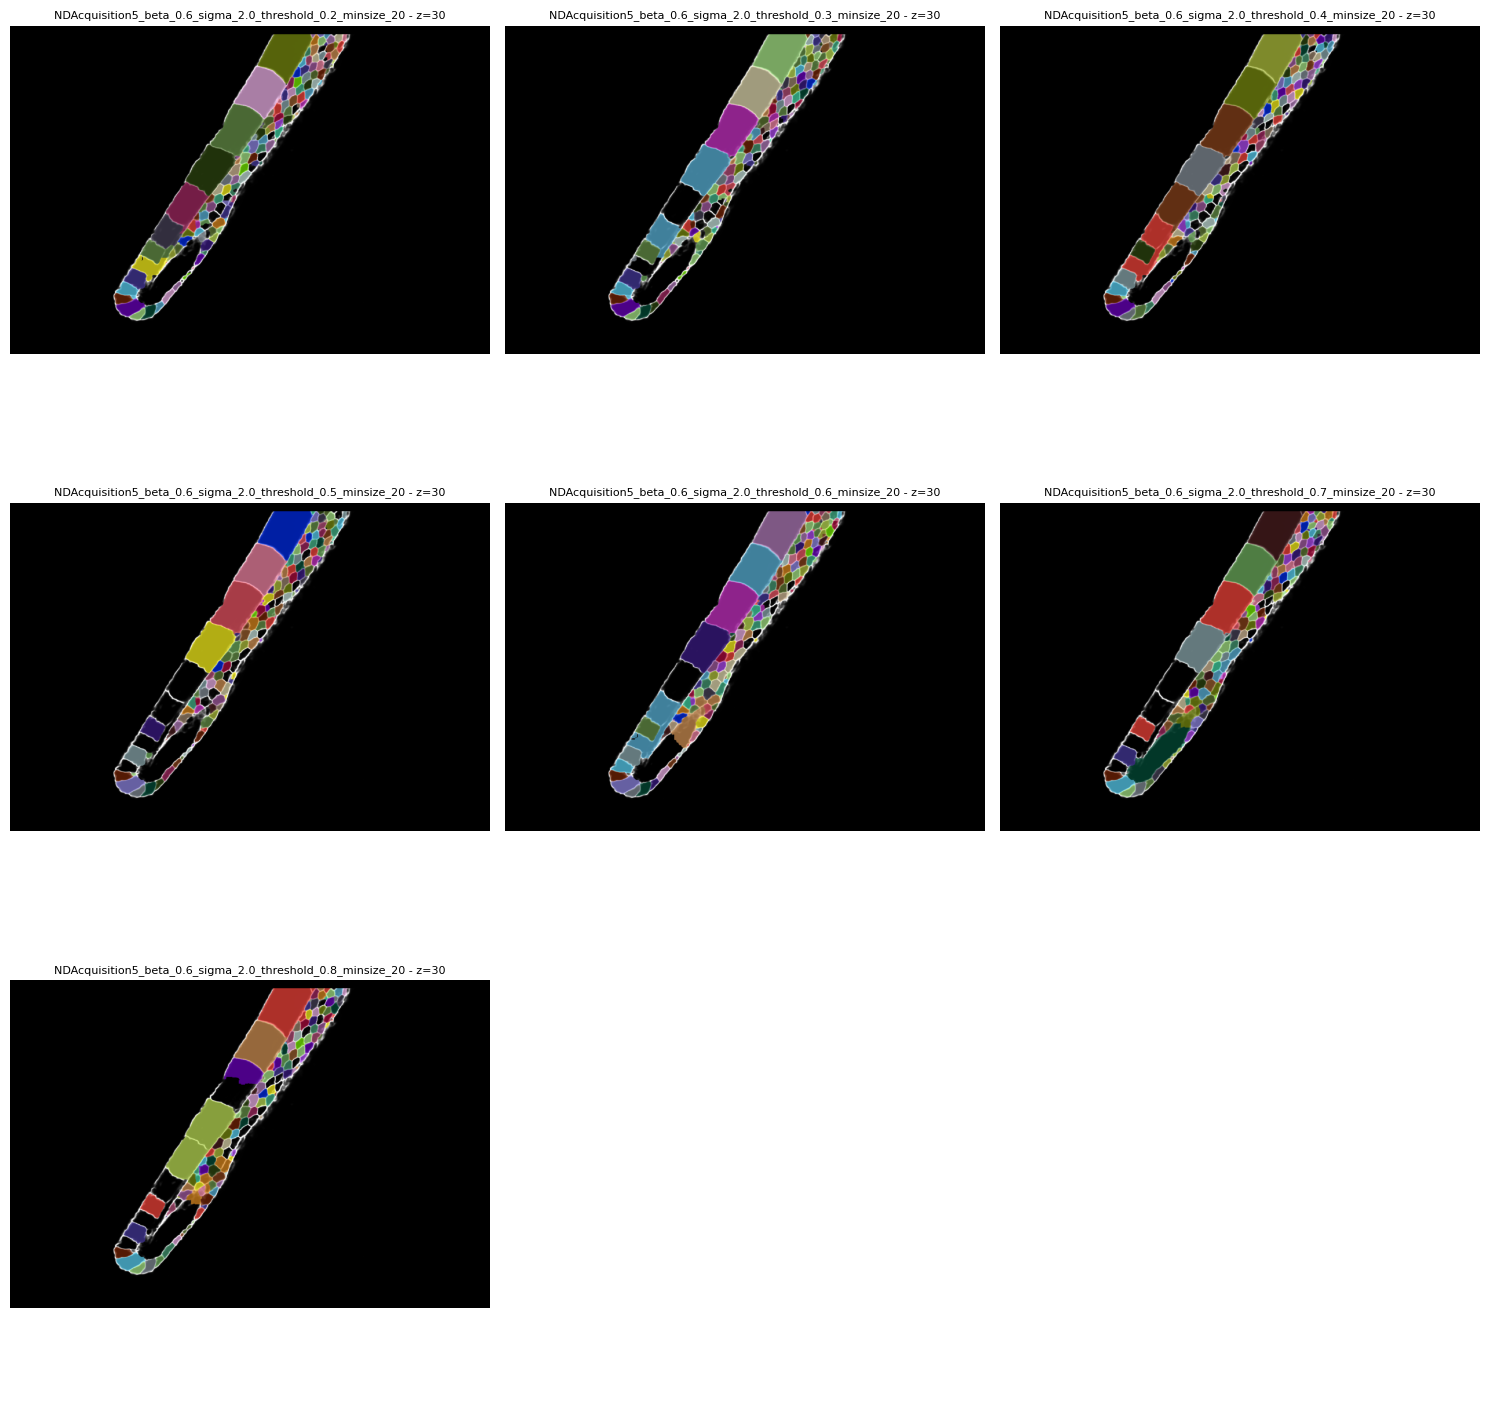

Figura guardada en: ND5_multicut_test5_Cost2edgesnorm_filter350.png


In [5]:
final_seg_params = func.run_multicut_test(pmaps_32_invert,configs_ws,beta_values,weighting_exponent=2.0)

func.plot_segmentation_screenshots(
    final_seg_params=final_seg_params,
    pmaps_image=pmaps_32_invert,
    filenam_without_ext="NDAcquisition5",
    z_plane=30,
    save_path="ND5_multicut_test5_Cost2edgesnorm_filter350.png",
    dpi=1000
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


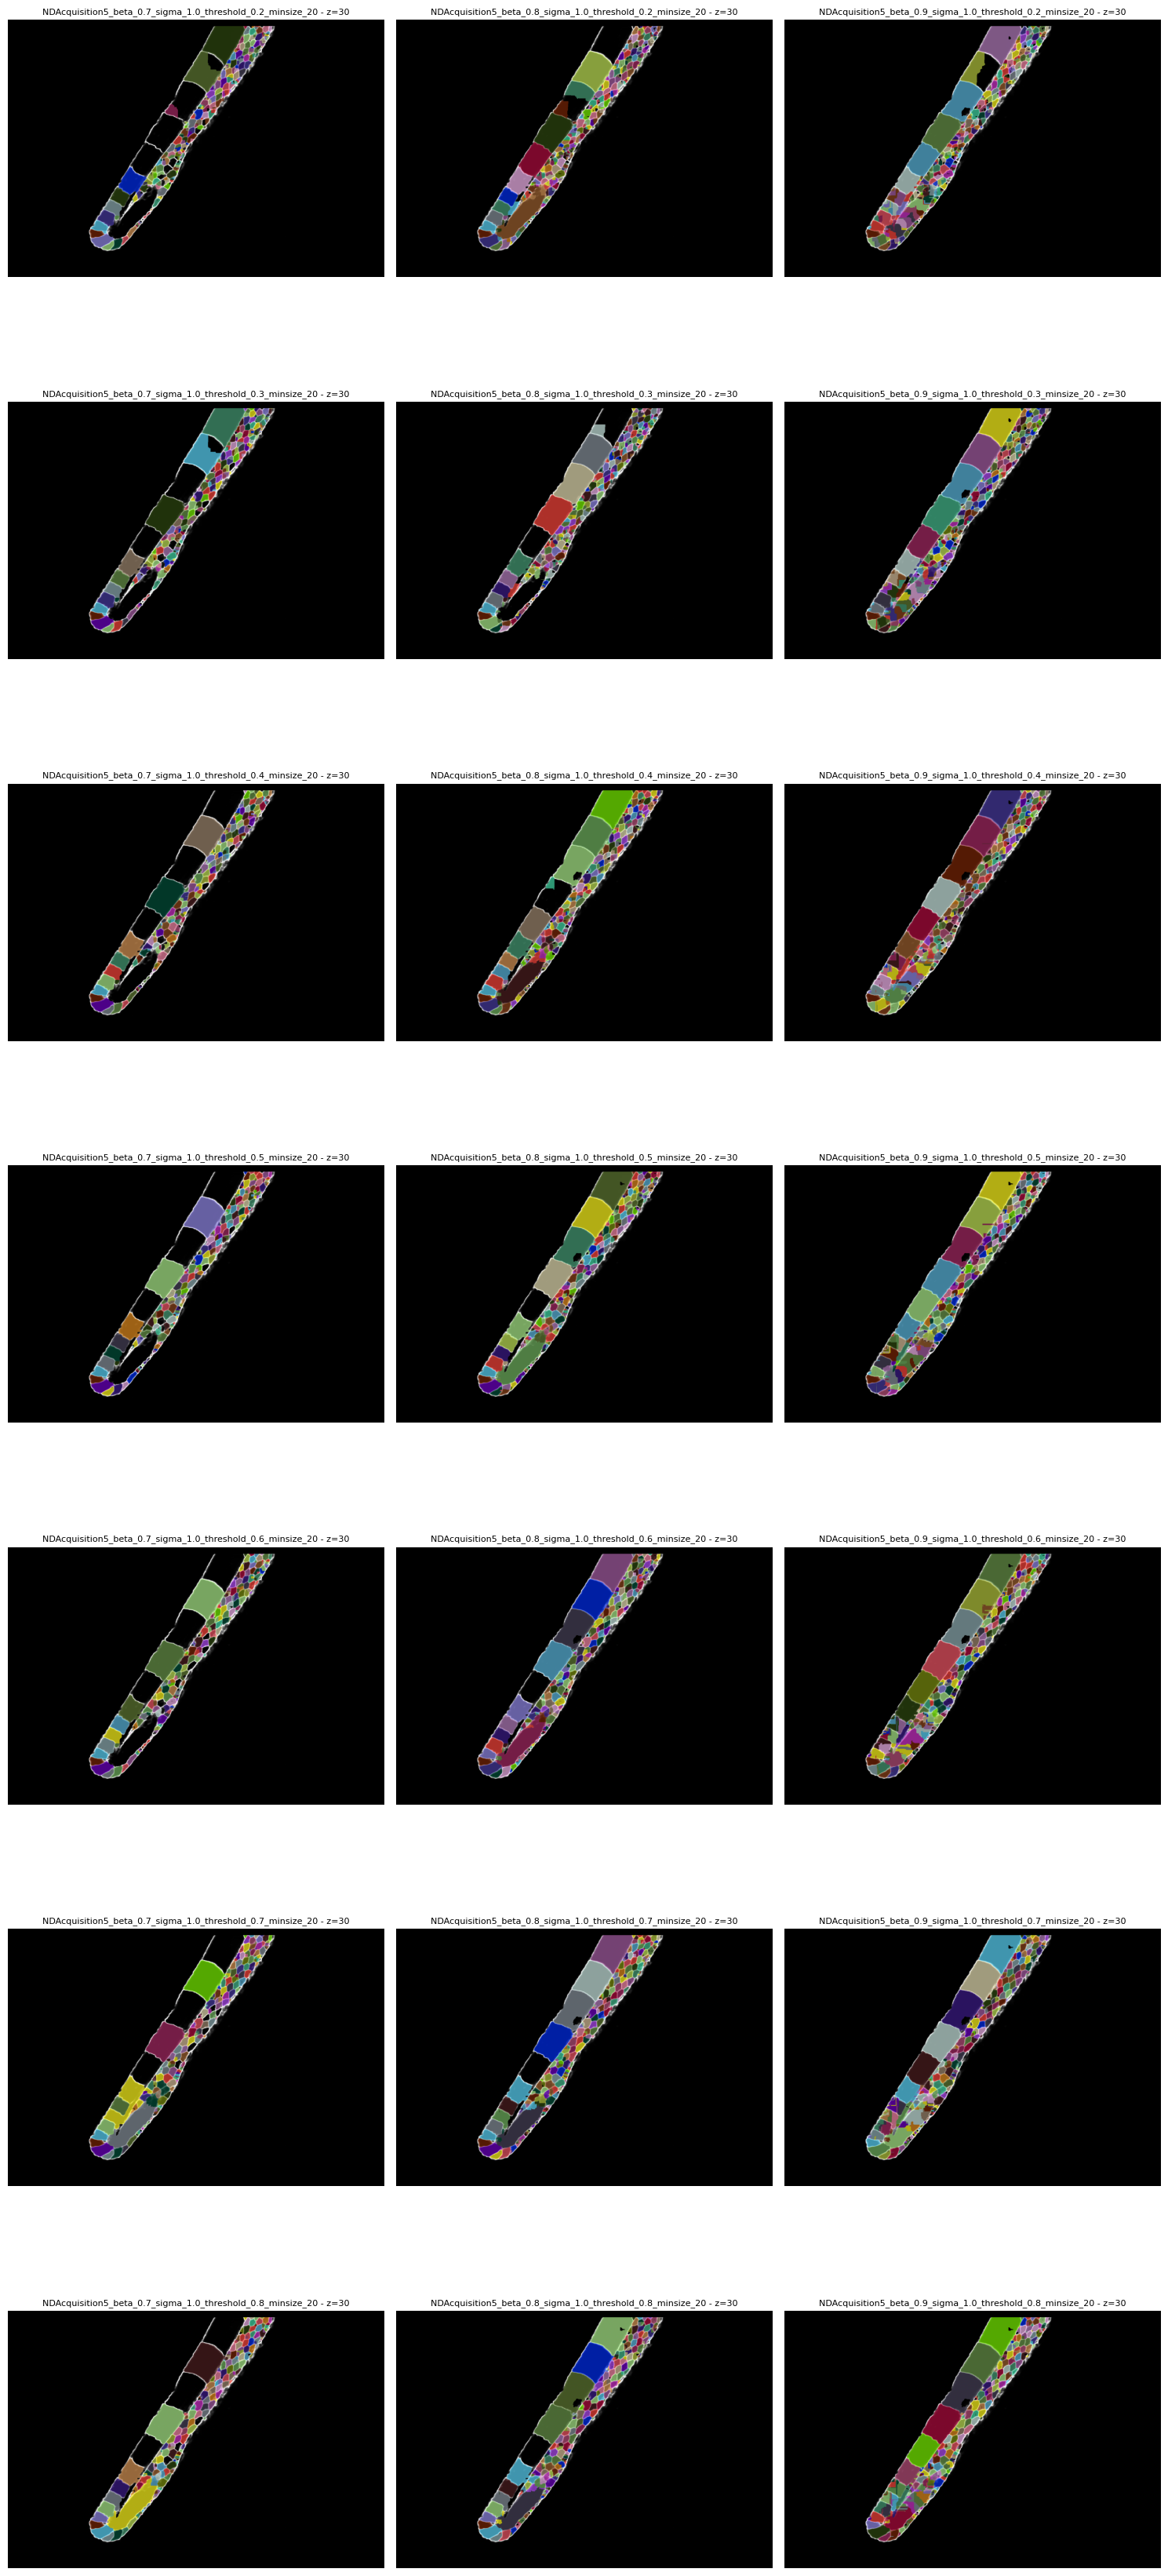

Figura guardada en: ND5_multicut_test2_filter350.png


In [7]:
final_seg_params = run_multicut_test(pmaps_32_invert,configs_ws,beta_values)

plot_segmentation_screenshots(
    final_seg_params=final_seg_params,
    pmaps_image=pmaps_32_invert,
    filenam_without_ext="NDAcquisition5",
    z_plane=30,
    save_path="ND5_multicut_test2_filter350.png",
    dpi=1000
)

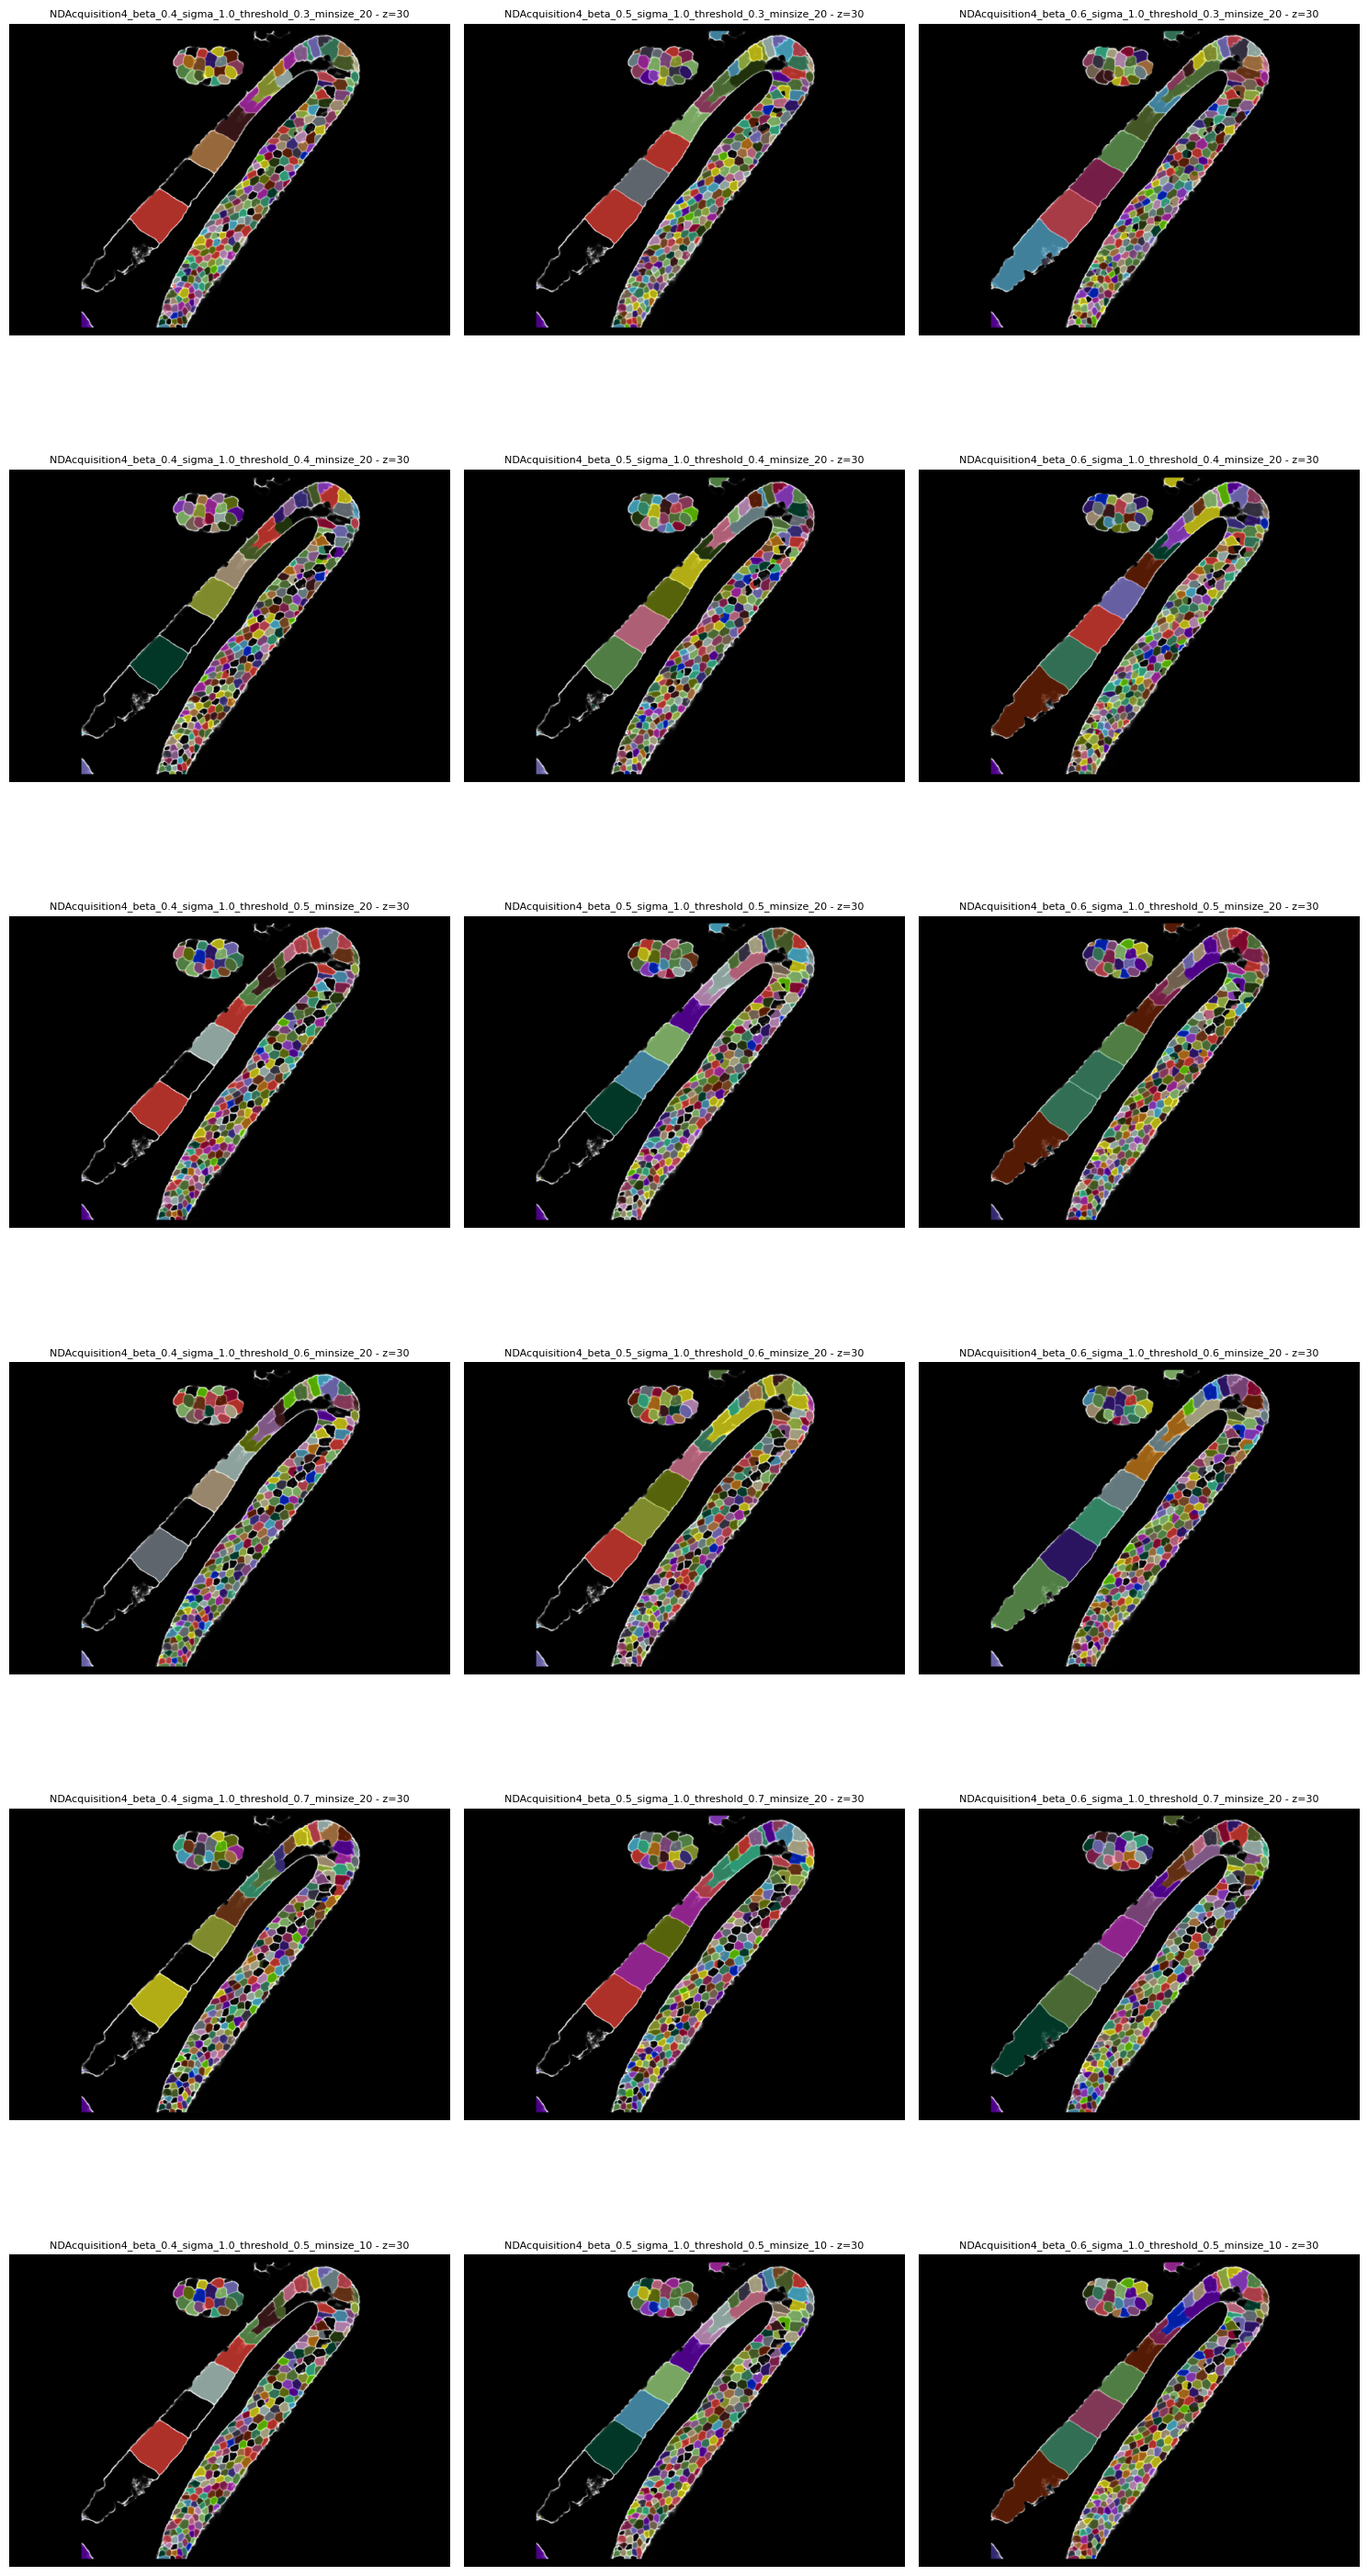

Figura guardada en: ND4_multicut_test_filter350.png


2025-05-04 22:46:46.929 python[1743:1488104] The class 'NSSavePanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Best set of parameters:
NDAcquisition2
beta_0.5_sigma_1.0_threshold_0.7_minsize_20  

NDAcquisition4:
beta_0.4_sigma_1.0_threshold_0.3_minsize_20
beta_0.3_sigma_1.0_threshold_0.4_minsize_20
filter max size 350
NDAcquisition4_beta_0.6_sigma_1.0_threshold_0.3_minsize_20 #don't segment empty space

In [10]:
import os
from tifffile import imsave

# Directorio donde se guardarán las imágenes
output_dir = "napari_layers_original_format"
os.makedirs(output_dir, exist_ok=True)
viewer = napari.Viewer()

# Guardar todas las capas visibles con el formato original
for layer in viewer.layers:
    if hasattr(layer, "data"):  # Verificar si la capa tiene datos
        layer_data = layer.data
        layer_name = layer.name
        #print(layer_name)
        

        # Crear el nombre del archivo basado en el nombre de la capa
        filename2 = os.path.join(output_dir, f"{layer_name}.tif")

        # Verificar si la capa tiene propiedades específicas para guardar
        if isinstance(layer_data, np.ndarray):
            # Guardar los datos de la capa sin alterar su formato
            imsave(filename2, layer_data)
        else:
            # Si el formato es complejo, agrega lógica específica aquí
            raise ValueError(f"No se puede guardar la capa {layer_name} debido a un formato inesperado.")

        print(f"Guardado: {filename2}")

print(f"Todas las capas visibles se guardaron en {output_dir}")


Todas las capas visibles se guardaron en napari_layers_original_format
